In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hotels/hotel.xlsx


In [2]:
%%capture
!pip install interpret
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install openpyxl

In [3]:
import pandas as pd
import numpy as np

# Scikit-learn and imbalanced-learn imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
import optuna

In [4]:
# Construct the full path to your CSV file
xlsx_file_path = '/kaggle/input/hotels/hotel.xlsx'

# Load the CSV file into a DataFrame
data = pd.read_excel(xlsx_file_path)

In [5]:
# =============================================================================
# 1. Create a custom transformer for data cleaning and feature engineering
# =============================================================================
class BookingDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # No hyperparameters needed here (but you could add some if desired)
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Work on a copy so we do not modify the original DataFrame
        df = X.copy()

        # --- Filter out problematic rows ---
        # Remove rows where adults, children, and babies are all zero
        mask = (df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)
        df = df.loc[~mask]

        # Remove rows where adults is zero but children or babies are positive
        mask = (df['adults'] == 0) & ((df['children'] > 0) | (df['babies'] > 0))
        df = df.loc[~mask]

        # --- Fill missing values and create features ---
        # Fill missing 'agent' with max(agent)+1
        df['agent'] = df['agent'].fillna(df['agent'].max() + 1)

        # Fill missing 'children' with 0 (so that is_family can be computed)
        df['children'] = df['children'].fillna(0)
        df['is_family'] = (df['children'] + df['babies']) > 0

        # Drop columns not needed
        df = df.drop(['company', 'children', 'babies'], axis=1)

        # --- Create country-based features ---
        european_countries = [
            'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'CHE', 'AUT', 'SWE', 'POL', 
            'RUS', 'NOR', 'ROU', 'FIN', 'DNK', 'LUX', 'TUR', 'HUN', 'CZE', 'GRC', 'SRB', 'HRV', 
            'EST', 'LTU', 'BGR', 'UKR', 'SVK', 'ISL', 'SVN', 'LVA', 'CYP', 'MNE', 'AND', 'MLT', 
            'GIB', 'BIH', 'ALB', 'MKD', 'LIE', 'SMR', 'FRO', 'MCO'
        ]
        df['portugal'] = (df['country'] == 'PRT').astype(int)
        df['european'] = df['country'].isin(european_countries).astype(int)
        df['rest_of_the_world'] = ((~df['country'].isin(european_countries)) & (df['country'] != 'PRT')).astype(int)
        df = df.drop('country', axis=1)

        # --- Process room types ---
        df['room_status'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)
        df = df.drop(['reserved_room_type', 'assigned_room_type'], axis=1)

        # --- Create stay-related features ---
        df['total_stay_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
        df = df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)

        # --- Create cancellation and request indicators ---
        df['cancellation_risk'] = (df['previous_cancellations'] > 0).astype(int)
        df = df.drop('previous_cancellations', axis=1)

        df['special_request_indicator'] = (df['total_of_special_requests'] > 0).astype(int)
        df = df.drop('total_of_special_requests', axis=1)

        df['waiting_list_indicator'] = (df['days_in_waiting_list'] > 0).astype(int)
        df = df.drop('days_in_waiting_list', axis=1)

        df['booking_changes_indicator'] = (df['booking_changes'] > 0).astype(int)
        df = df.drop('booking_changes', axis=1)

        df['required_car_spaces_indicator'] = (df['required_car_parking_spaces'] > 0).astype(int)
        df = df.drop('required_car_parking_spaces', axis=1)

        # --- Process arrival date information ---
        df['arrival_date'] = pd.to_datetime(
            df['arrival_date_day_of_month'].astype(str) + ' ' +
            df['arrival_date_month'] + ' ' +
            df['arrival_date_year'].astype(str),
            errors='coerce'
        )
        df['arrival_day_name'] = df['arrival_date'].dt.day_name()
        seasons = {
            'Winter': ['December', 'January', 'February'],
            'Spring': ['March', 'April', 'May'],
            'Summer': ['June', 'July', 'August'],
            'Fall': ['September', 'October', 'November']
        }
        def get_season(month):
            for season, months in seasons.items():
                if month in months:
                    return season
            return 'Unknown'
        df['season'] = df['arrival_date_month'].apply(get_season)
        df = df.drop(['arrival_date_day_of_month', 'arrival_date_month', 
                      'arrival_date_week_number', 'arrival_date'], axis=1)

        return df

# =============================================================================
# 2. Specify which columns are numerical and which are categorical
#    (These lists match the column names that exist after cleaning.)
# =============================================================================
numerical_columns = ['adults', 'adr', 'lead_time', 'total_stay_nights']
categorical_columns = [
    'market_segment', 'distribution_channel', 'portugal', 'european',
    'rest_of_the_world', 'deposit_type', 'customer_type',
    'is_repeated_guest', 'required_car_spaces_indicator',
    'room_status', 'season', 'is_family', 'cancellation_risk',
    'special_request_indicator', 'waiting_list_indicator', 'agent',
    'arrival_day_name', 'arrival_date_year', 'booking_changes_indicator', 'meal'
]

# =============================================================================
# 3. Build the preprocessing pipeline
#    - First, run the custom cleaning transformer.
#    - Next, use a ColumnTransformer to standardize the numerical columns and
#      one-hot encode the categorical ones.
# =============================================================================
preprocessing_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns)
        ]
    ))
])

# =============================================================================
# 4. (Outside the pipeline) Split your data and apply the pipeline
#    Note: In your original code you first separated the two hotel types.
#          Here we do that before preprocessing.
# =============================================================================
# Assume your raw DataFrame is named "data"
# (Make sure 'data' contains all the columns needed by the transformer.)

# 1. Clean the full dataset first
data_clean = BookingDataTransformer().fit_transform(data)

# 2. Then split by hotel type
H1 = data_clean.loc[data_clean['hotel'] == 'Resort Hotel'].drop('hotel', axis=1)
H2 = data_clean.loc[data_clean['hotel'] == 'City Hotel'].drop('hotel', axis=1)


# For demonstration, we work with H1.
# IMPORTANT: Remove the target column ('is_canceled') from X.
X = H1.drop('is_canceled', axis=1)
y = H1['is_canceled']

# Split into train (70%), validation (15%), and test (15%).
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp
)

# Fit the preprocessing pipeline on the training features and transform all sets
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_val_processed   = preprocessing_pipeline.transform(X_val)
X_test_processed  = preprocessing_pipeline.transform(X_test)

# =============================================================================
# 5. (Optional) Apply SMOTE on the training data to balance the classes
# =============================================================================
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# =============================================================================
# 6. Example: An objective function for Optuna that builds and evaluates a model
# =============================================================================
def objective(trial):
    # Suggest hyperparameters for the LightGBM classifier.
    max_depth = trial.suggest_int('max_depth', 3, 15)  # -1 means no limit
    num_leaves = trial.suggest_int('num_leaves', 24, 256)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.2, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1500)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    min_split_gain = trial.suggest_float('min_split_gain', 0.0, 0.2)
    max_bin = trial.suggest_int('max_bin', 128, 256)

    
    # Initialize the classifier with the hyperparameters.
    clf_lgb = LGBMClassifier(
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_split_gain=min_split_gain,
        max_bin=max_bin,
        objective="binary",
        random_state=0,
        verbose=-1,
        n_jobs=-1
    )
    
    # Fit on the SMOTE-augmented training data.
    clf_lgb.fit(X_train_smote, y_train_smote)
    
    # Predict on the validation set.
    y_pred = clf_lgb.predict(X_val_processed)
    
    # Return the validation accuracy (Optuna will maximize this).
    return accuracy_score(y_val, y_pred)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [6]:
# Disable the default handler to prevent any logging from Optuna
optuna.logging.disable_default_handler()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=501)  # Perform 501 trials

In [7]:
# Print the best parameters and accuracy
print("Best Parameters:", study.best_params)
print("Best Validation Accuracy:", study.best_value)

Best Parameters: {'max_depth': 11, 'num_leaves': 82, 'min_data_in_leaf': 55, 'learning_rate': 0.039530639540291033, 'n_estimators': 1123, 'subsample': 0.582958518341605, 'colsample_bytree': 0.6175675122673138, 'reg_alpha': 0.00440126091685891, 'reg_lambda': 1.3609039554463064e-05, 'min_split_gain': 0.010417346710853436, 'max_bin': 244}
Best Validation Accuracy: 0.9079785241603197


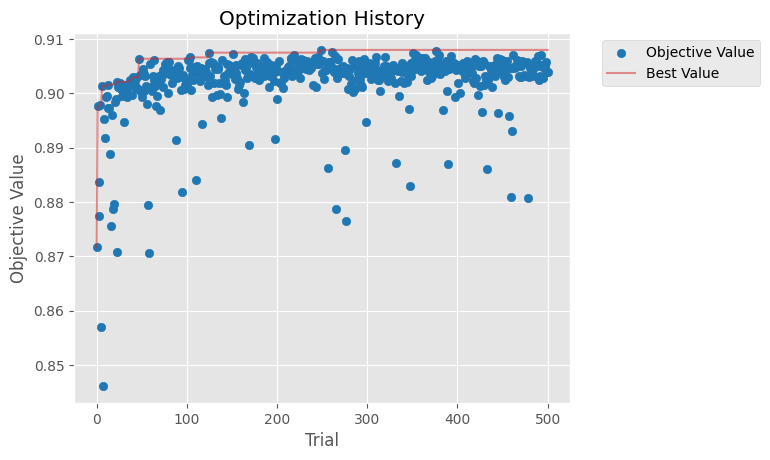

In [8]:
import optuna
from optuna.visualization import matplotlib as optuna_matplotlib
import matplotlib.pyplot as plt

import warnings
from optuna.exceptions import ExperimentalWarning

# Suppress all ExperimentalWarning warnings
warnings.simplefilter('ignore', category=ExperimentalWarning)

# Plot optimization history
optuna_matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.xlabel("Trial")
plt.ylabel("Objective Value")
plt.show()

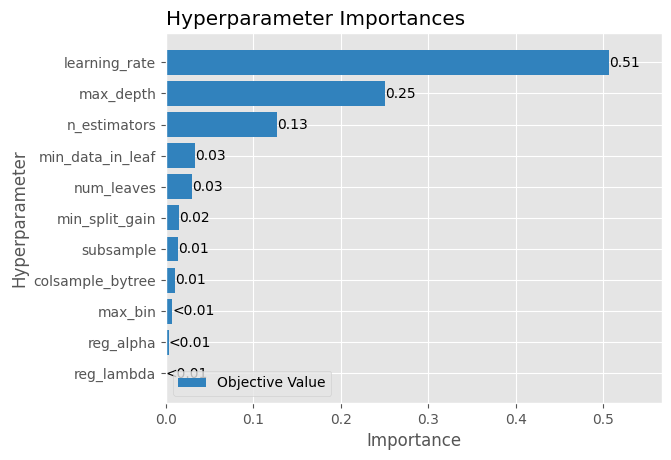

In [9]:
# Plot hyperparameter importance
optuna_matplotlib.plot_param_importances(study)
plt.xlabel("Importance")
plt.ylabel("Hyperparameter")
plt.show()

In [10]:
# Now, retrain the model on the combined training and validation data
# Combine training and validation data
# Convert X_val_processed to a dense array if it's sparse
if hasattr(X_val_processed, "toarray"):
    X_val_processed = X_val_processed.toarray()
    
# Combine SMOTE-processed training data and processed validation data
X_train_full = np.vstack((X_train_smote, X_val_processed))
y_train_full = np.hstack((y_train_smote, y_val))

# Apply SMOTE to the combined data
smote = SMOTE(random_state=0)
X_train_full_smote, y_train_full_smote = smote.fit_resample(X_train_full, y_train_full)

# Final evaluation on test set with best parameters
best_model = LGBMClassifier(**study.best_params, random_state=0, n_jobs=-1)
best_model.fit(X_train_full_smote, y_train_full_smote)

X_test_processed = preprocessing_pipeline.transform(X_test)
# If X_test_processed is sparse, convert it to a dense array:
if hasattr(X_test_processed, "toarray"):
    X_test_processed = X_test_processed.toarray()

test_pred = best_model.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Final Test Combined Training Data Accuracy: {test_accuracy:.4f}")

Final Test Combined Training Data Accuracy: 0.9047
